In [1]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

from datetime import datetime
from datetime import date
from dateutil import parser

from collections import defaultdict

import warnings
import time

In [2]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Database connection

The data is in sqlite tables. We read the data from tables into dataframes in the following cells

In [3]:
# open connection 
conn = sqlite3.connect("data/database.sqlite")
cur = conn.cursor()

In [4]:
def executeQuery(cur, query):
    cur.execute(query)
    return cur.fetchall()

In [5]:
def read_table_to_df(table):
    query = "SELECT * from " + table
    return pd.read_sql_query(query, conn)

In [6]:
# list of all tables
q_all_tables = """SELECT name FROM sqlite_master
    WHERE type='table';"""
all_tables = executeQuery(cur, q_all_tables)
useful_tables = all_tables[1:]
print(useful_tables)

[('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


In [7]:
df_matches = read_table_to_df("Match");
df_player = read_table_to_df("PLAYER");
df_team = read_table_to_df("Team");
df_player_attr = read_table_to_df("Player_Attributes");
df_country = read_table_to_df("Country");
df_league = read_table_to_df("League");
df_team_attr = read_table_to_df("Team_Attributes");

In [8]:
df_matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [9]:
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [10]:
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [11]:
df_player_attr.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [12]:
df_country.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [13]:
df_league.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [14]:
df_team_attr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [15]:
# ranges
df_match_info = df_matches.iloc[:, :11]
df_match_player_positions = df_matches.iloc[:, 11:55]
df_match_stats = df_matches.iloc[:, 77:85]
df_match_betting = df_matches.iloc[:, 85:]
df_match_stats.head()

,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None
3,None,None,None,None,None,None,None,None
4,None,None,None,None,None,None,None,None


In [16]:
font = {'family': 'Helvetica', 'size': 12}

In [17]:
def plot_match_bar(X, y, home_wdl_percentage):
    X = np.array(X)
    y = np.array(y)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300)
    
    # Plot the first subplot
    bars1 = ax1.bar(X, y)
    
    for bar in bars1:
        bar.set_color('#CBCBCB')

    ax1.set_xticks(X)
    ax1.set_xticklabels(X, fontdict=font)

    ax1.set_yticks(y)
    ax1.set_yticklabels(y, fontdict=font)

    ax1.set_xlabel('Column group', fontdict=font)
    ax1.set_ylabel('Percentage of NaN values', fontdict=font)
    ax1.set_title('Percentage of NaN values by column groups', fontdict=font)
    
    # Plot the second subplot
    keys = list(home_wdl_percentage.keys())
    values = list(home_wdl_percentage.values())
    values = [float("{:.2f}".format(val)) for val in values]
    bars2 = ax2.bar(keys, values)
    
    for bar in bars2:
        bar.set_color('#CBCBCB')
    
    ax2.set_xticks(keys)
    ax2.set_xticklabels(keys, fontdict=font)
    
    ax2.set_yticks(values)
    ax2.set_yticklabels(values, fontdict=font)

    ax2.set_xlabel('Result category', fontdict=font)
    ax2.set_ylabel('Percentage of results', fontdict=font)
    ax2.set_title('Percentage of results by category', fontdict=font)
    
    plt.tight_layout()
    plt.savefig('data/figs/match_bar_plot.pdf')
    plt.show()

In [18]:
def percentage_nan_df(df):
    total_cells = df.size
    total_nan = df.isna().sum().sum()
    percentage_of_nan = (total_nan / total_cells) * 100
    result = "{:.2f}".format(percentage_of_nan)
    return float(result)

In [19]:
def home_team_wdl(df_matches):
    df_matches_tmp = df_matches
    df_matches_tmp['goal_diff'] = df_matches_tmp['home_team_goal'].sub(df_matches_tmp['away_team_goal'])
    df_matches_tmp['home_team_wdl'] = df_matches_tmp['goal_diff'].apply(lambda x: 'W' if x > 0 else 'D' if x == 0 else 'L')
    result = df_matches_tmp['home_team_wdl'].value_counts()
    total = result.sum()
    result = (result/total)*100
    return result.to_dict()


In [20]:
home_wdl_percentage = home_team_wdl(df_matches)
print(home_wdl_percentage)

{'W': 45.87166557604219, 'L': 28.738596558759, 'D': 25.389737865198814}


In [21]:
df_match_info_pc = percentage_nan_df(df_match_info);
df_match_player_positions_pc = percentage_nan_df(df_match_player_positions);
df_match_stats_pc = percentage_nan_df(df_match_stats);
df_match_betting_pc = percentage_nan_df(df_match_betting)

df_match_X = ['Match Info', 'Player Positions', 'Match Statistics', 'Betting']
df_match_y = [df_match_info_pc, df_match_player_positions_pc, df_match_stats_pc, df_match_betting_pc]
print(type(df_match_y[0]))
print(df_match_X)
print(df_match_y)

<class 'float'>
['Match Info', 'Player Positions', 'Match Statistics', 'Betting']
[0.0, 7.05, 45.28, 26.11]


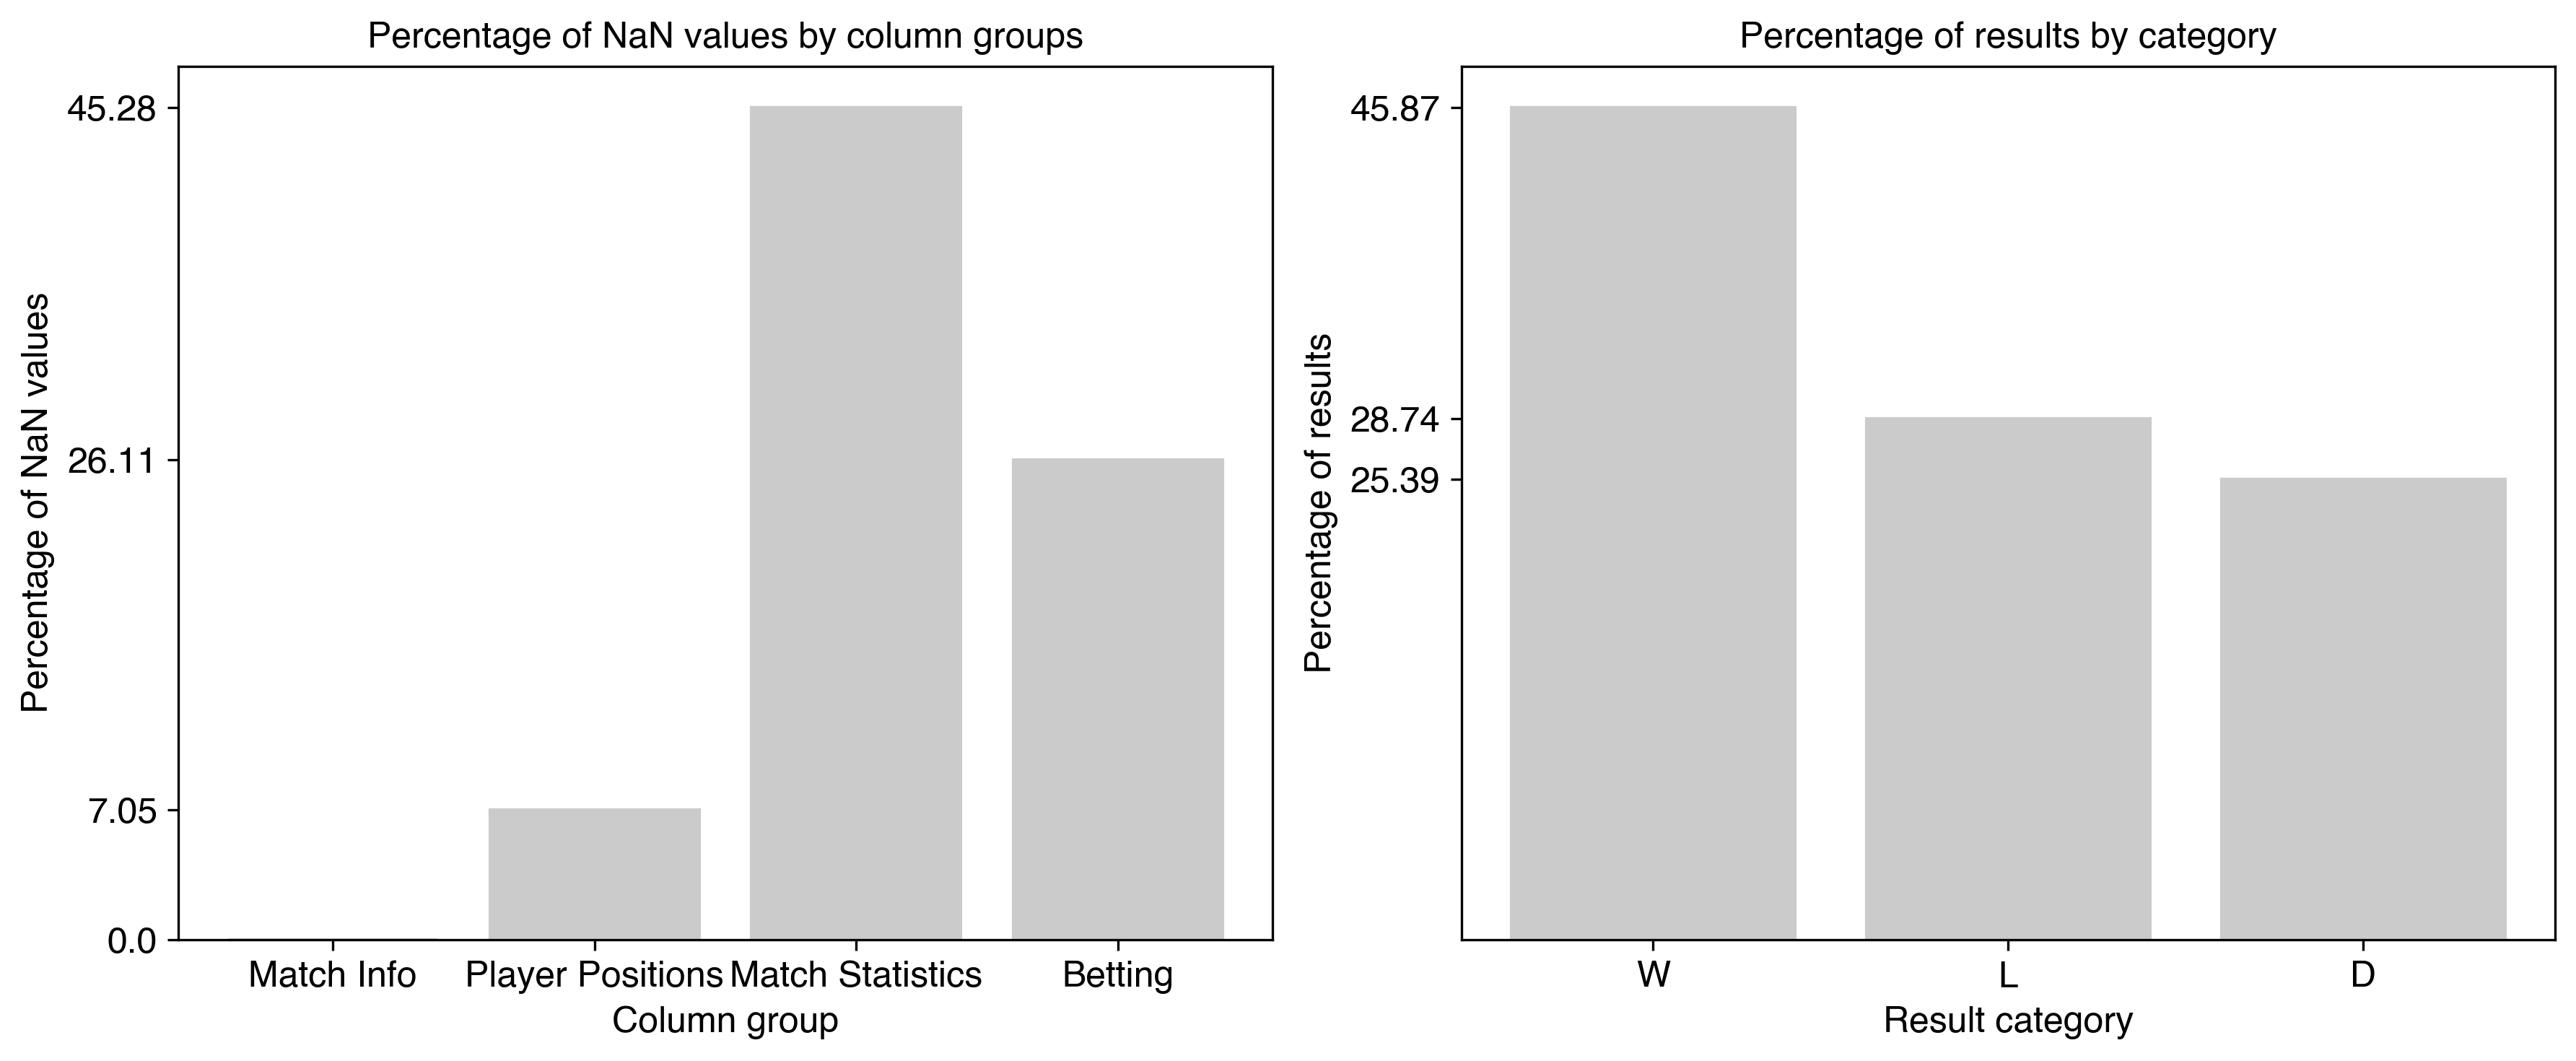

In [22]:
plot_match_bar(df_match_X, df_match_y, home_wdl_percentage)

In [23]:
def plot_player_attr_iqr(df_player, df_player_attr):
    # Extract height and weight columns from DataFrame
    height = df_player['height']
    weight = df_player['weight']
    overall_rating = df_player_attr['overall_rating']
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=300)

    # Plot IQR for height and weight
    gray_color = '#CBCBCB'
    sns.boxplot(y=height, ax=axs[0], color=gray_color)
    sns.boxplot(y=weight, ax=axs[1], color=gray_color)
    sns.boxplot(y=overall_rating, ax=axs[2], color=gray_color)
    

    # Set axis labels and title
    axs[0].set_ylabel('Height (cm)', fontdict=font)
    axs[1].set_ylabel('Weight (lbs)', fontdict=font)
    axs[2].set_ylabel('Overall Rating ', fontdict=font)
    fig.suptitle('Interquartile Range (IQR) for Height and Weight', font=font)

    # Show the plot
    plt.savefig('data/figs/players_iqr.pdf')
    plt.show()

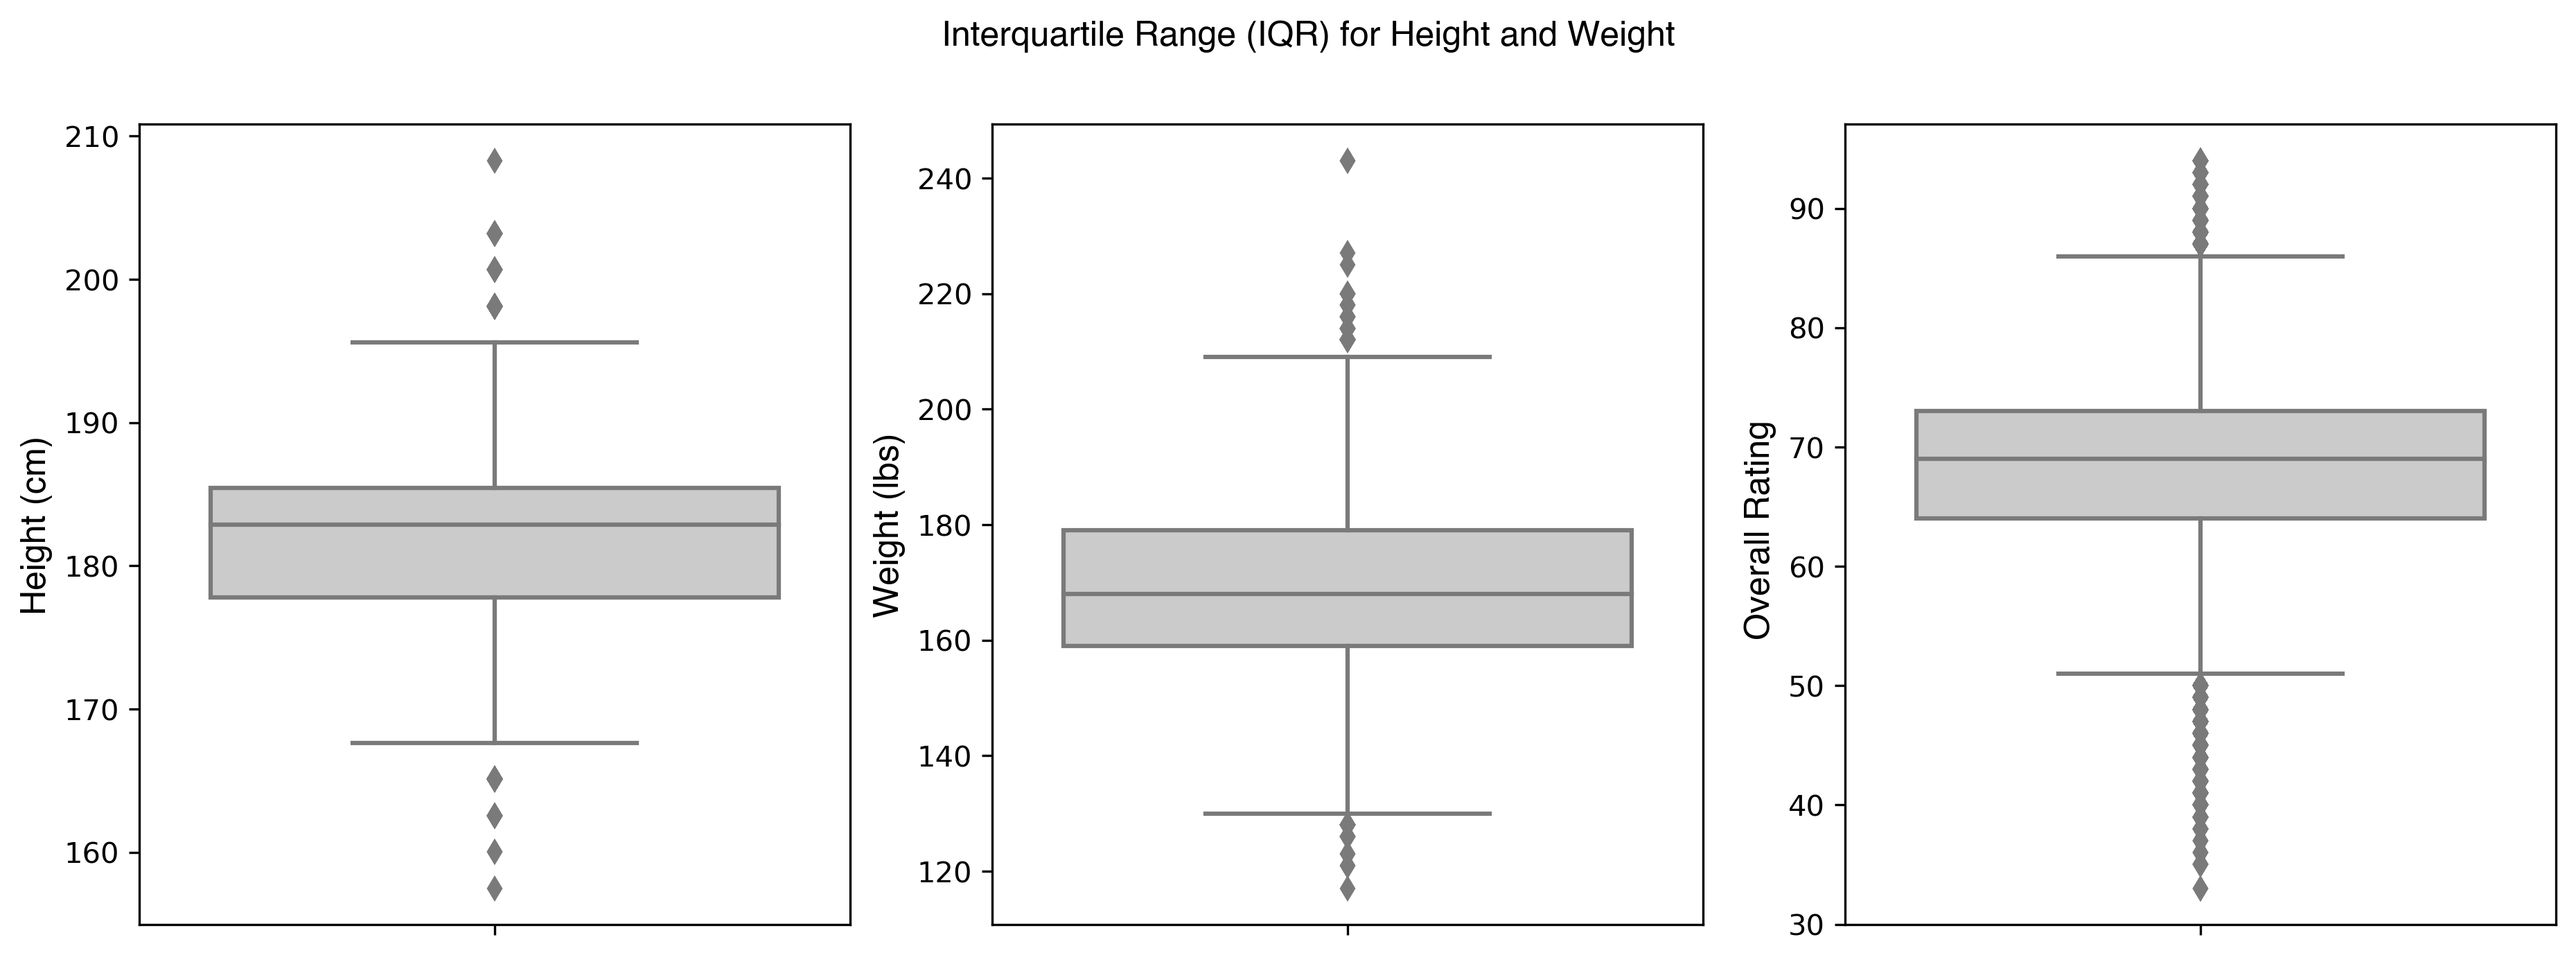

In [24]:
plot_player_attr_iqr(df_player, df_player_attr)

In [25]:
des_matches = df_matches.describe()
des_player = df_player.describe()
des_team = df_team.describe()
des_player_attr = df_player_attr.describe()
des_country = df_country.describe()
des_league = df_league.describe()
des_team_attr = df_team_attr.describe()

In [26]:
tr_matches = des_matches.transpose()
tr_player = des_player.transpose()
tr_team = des_team.transpose()
tr_player_attr = des_player_attr.transpose()
tr_country = des_country.transpose()
tr_league = des_league.transpose()
tr_team_attr = des_team_attr.transpose()

df_all_stats = pd.concat([tr_matches, tr_player, tr_team, tr_player_attr, tr_country, tr_league, tr_team_attr], axis=0)

In [27]:
styler = df_all_stats.style
stats_table = styler.to_latex()

with open('data/stats_table.tex', 'w') as f:
    f.write(stats_table)